In [1]:
import os
import numpy as np
import itertools
train_path = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/'
annotations_path = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'

In [2]:
def search_correct_annotations_npy(dirname,filename):
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filename = [file for file in file_list if search_filename in file if file.endswith("npy")]
    
    return filename

In [3]:
train_list = os.listdir(train_path)
train_list = [file for file in train_list if file.endswith('.npy')]
print(len(train_list))

38


In [4]:
train_save_path = train_path + 'each/'
os.makedirs(train_save_path,exist_ok=True)
for i in range(6):
    os.makedirs(train_save_path+'%d/'%i,exist_ok=True)

In [5]:
print(train_save_path)

D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/each/


In [6]:
# total_index = 0
# for filename in train_list:
#     signals = np.load(train_path+filename)
#     annotations_name = search_correct_annotations_npy(annotations_path,filename)[0]
#     labels = np.load(annotations_path+annotations_name)
    
#     sample_rate = 100
#     sec = 30
    
#     for index in range(len(labels)):
#         save_signals = signals[0,index*sample_rate*sec:(index+1)*sample_rate*sec]
#         save_file = train_save_path+'%d/%d'%(labels[index],total_index)
#         np.save(save_file,save_signals)
#         total_index += 1

In [7]:
train_signals_path = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/each/'

print(len(os.listdir(train_signals_path+'0/')))
print(len(os.listdir(train_signals_path+'1/')))
print(len(os.listdir(train_signals_path+'2/')))
print(len(os.listdir(train_signals_path+'3/')))
print(len(os.listdir(train_signals_path+'4/')))
print(len(os.listdir(train_signals_path+'5/')))


4258
2762
17340
5575
7522
59


In [8]:
check_label = np.zeros(6)
for filename in train_list:
    annotations_name = search_correct_annotations_npy(annotations_path,filename)[0]
    labels = np.load(annotations_path+annotations_name)
    for i in labels:
        check_label[i] += 1
    
    

In [9]:
print(check_label)

[ 4258.  2762. 17340.  5575.  7522.    59.]


In [10]:
import numpy as np
import os
import time
import matplotlib.pylab as plt
from  torch.utils.data import Dataset
from torchvision import datasets, transforms
import sys
import random
import math
import warnings
import pandas as pd

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def data_preprocessing_torch(signals): # 하나의 데이터셋에 대한 data_preprocessing (using torch)
    signals = (signals - signals.mean(dim=1).unsqueeze(1))/signals.std(dim=1).unsqueeze(1)

    return signals



def data_preprocessing_oneToOne_torch(signals,min,max,max_value):
    signals_std = (signals + max_value) / (2*max_value)
    signals_scaled = signals_std * (max - min) + min
    return signals_scaled

def data_preprocessing_minmax_torch(signals,min,max):
    signals_std = (signals - signals.min(dim=1).unsqueeze(1)) / (
            signals.max(dim=1).unsqueeze(1) - signals.min(dim=1).unsqueeze(1))
    signals_scaled = signals_std * (max - min) + min
    return signals_scaled

def get_dataset_one_channel_norm_withoutCut(dirname,annotations_dir,data_path,use_noise=True,epsilon=0.5,noise_scale=2e-6,preprocessing=True,norm_methods='Standard'):
    # npy read!
    path = dirname + data_path
    signals = np.load(path)

    signals = torch.from_numpy(signals).float().to(device)

    if use_noise:
        if np.random.rand() < epsilon:
            # noise = np.random.normal(loc=0,scale=noise_scale,size=signals.shape)
            # signals = signals + noise
            noise = torch.normal(mean=0., std=noise_scale, size=signals.shape).to(device)
            signals = signals + noise

    if preprocessing:
        if norm_methods == 'Standard':
            signals = data_preprocessing_torch(signals)
        elif norm_methods == 'minmax':
            signals = data_preprocessing_minmax_torch(signals,0,1)
        elif norm_methods == 'oneToOne':
            signals = data_preprocessing_oneToOne_torch(signals,-1,1,1e-4)
    label = get_annotations(annotations_dir, data_path)
    return signals, label

# model conv layer weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        torch.nn.init.xavier_uniform_(m.weight.data)
        
def suffle_dataset_list(dataset_list): # 데이터 셔플
    random.shuffle(dataset_list)
    return dataset_list


# npy파일을 통해 label을 가져오는 함수
def get_annotations(label_dir,file_name):
    label_path = label_dir + file_name
    label = np.load(label_path)
    return label

def signals_expand_torch_one_channel(signals): # 2차원 데이터를 3차원으로 변환 (8,N) -> (batch,8,6000) 형태로
    signals = signals.expand(1,1,-1)
    #print(signals.shape)
    signals = signals.transpose(2, 1) # 차원 변경
    signals = signals.reshape(-1, 3000, 1) # 형태 변환
    signals = signals.transpose(2, 1) # 차원 변경
    return signals

In [12]:

class DeepSleepNet_Classification(nn.Module):  # input channel = 8channel / output = 5
    def __init__(self,in_channel=1,out_channel=6,layer=[64,128,128,128],sample_rate = 100):
        super(DeepSleepNet_Classification, self).__init__()

        self.conv1_1d_big = nn.Conv1d(in_channels=in_channel, out_channels=layer[0], kernel_size=sample_rate*4, stride=sample_rate//2,
                                      padding=sample_rate*4//2,
                                      bias=False)
        self.conv2_1d_big = nn.Conv1d(in_channels=layer[0], out_channels=layer[1], kernel_size=6, stride=1, padding=3,
                                      bias=False)
        self.conv3_1d_big_1 = nn.Conv1d(in_channels=layer[1], out_channels=layer[2], kernel_size=6, stride=1, padding=3,
                                        bias=False)
        self.conv3_1d_big_2 = nn.Conv1d(in_channels=layer[2], out_channels=layer[3], kernel_size=6, stride=1, padding=3,
                                        bias=False)
        self.maxpool1_big = nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        self.maxpool2_big = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.conv1_1d_small = nn.Conv1d(in_channels=in_channel, out_channels=layer[0], kernel_size=sample_rate//2, stride=sample_rate//16,
                                        padding=sample_rate//2//2,
                                        bias=False)
        self.conv2_1d_small = nn.Conv1d(in_channels=layer[0], out_channels=layer[1], kernel_size=8, stride=1, padding=4,
                                        bias=False)
        self.conv3_1d_small_1 = nn.Conv1d(in_channels=layer[1], out_channels=layer[2], kernel_size=8, stride=1,
                                          padding=4,
                                          bias=False)
        self.conv3_1d_small_2 = nn.Conv1d(in_channels=layer[2], out_channels=layer[3], kernel_size=8, stride=1,
                                          padding=4,
                                          bias=False)
        self.maxpool1_small = nn.MaxPool1d(kernel_size=8, stride=8, padding=4)
        self.maxpool2_small = nn.MaxPool1d(kernel_size=4, stride=4, padding=2)

        self.ReLU = nn.ReLU()

        self.batch_norm_small_1 = nn.BatchNorm1d(64)
        self.batch_norm_small_2 = nn.BatchNorm1d(128)
        self.batch_norm_small_3 = nn.BatchNorm1d(128)
        self.batch_norm_small_4 = nn.BatchNorm1d(128)

        self.batch_norm_big_1 = nn.BatchNorm1d(64)
        self.batch_norm_big_2 = nn.BatchNorm1d(128)
        self.batch_norm_big_3 = nn.BatchNorm1d(128)
        self.batch_norm_big_4 = nn.BatchNorm1d(128)

        self.dropout_big = nn.Dropout(p=0.5)
        self.dropout_small = nn.Dropout(p=0.5)

        self.fc = nn.Linear(1280 + 2176, out_channel)  # big and small conv concat
        #self.fc2 = nn.Linear(1000, 5)  # big and small conv concat\
        # Dense 부분에서도 Bias없이 해볼 것!
        # self.fc = nn.Linear(384+8250,5,bias=False)

    def forward(self, input):
        # print("feature_extract_2d.shape : ", feature_extract_2d.shape)
        # 여기서 문제 발생 weight의 경우에는 [64 , 32 , 100] 이지만 input 이 2차원 [32, 750]이라 문제 발생!
        feature_big = self.conv1_1d_big(input)
        feature_big = self.batch_norm_big_1(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.maxpool1_big(feature_big)

        feature_big = self.dropout_big(feature_big)

        feature_big = self.conv2_1d_big(feature_big)
        feature_big = self.batch_norm_big_2(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.conv3_1d_big_1(feature_big)
        feature_big = self.batch_norm_big_3(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.conv3_1d_big_2(feature_big)
        feature_big = self.batch_norm_big_4(feature_big)
        feature_big = self.ReLU(feature_big)

        feature_big = self.maxpool2_big(feature_big)

        feature_small = self.conv1_1d_small(input)
        feature_small = self.batch_norm_small_1(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.maxpool1_small(feature_small)
        feature_small = self.dropout_small(feature_small)

        feature_small = self.conv2_1d_small(feature_small)
        feature_small = self.batch_norm_small_2(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.conv3_1d_small_1(feature_small)
        feature_small = self.batch_norm_small_3(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.conv3_1d_small_2(feature_small)
        feature_small = self.batch_norm_small_4(feature_small)
        feature_small = self.ReLU(feature_small)

        feature_small = self.maxpool2_small(feature_small)

        feature_big = torch.flatten(feature_big, 1)

        feature_small = torch.flatten(feature_small, 1)  # (batch, channel)

        output = torch.cat((feature_big, feature_small), dim=1)
        output = self.fc(output)

        return output


In [13]:
model = DeepSleepNet_Classification()
summary(model.cuda(),(1,3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 61]          25,600
       BatchNorm1d-2               [-1, 64, 61]             128
              ReLU-3               [-1, 64, 61]               0
         MaxPool1d-4               [-1, 64, 16]               0
           Dropout-5               [-1, 64, 16]               0
            Conv1d-6              [-1, 128, 17]          49,152
       BatchNorm1d-7              [-1, 128, 17]             256
              ReLU-8              [-1, 128, 17]               0
            Conv1d-9              [-1, 128, 18]          98,304
      BatchNorm1d-10              [-1, 128, 18]             256
             ReLU-11              [-1, 128, 18]               0
           Conv1d-12              [-1, 128, 19]          98,304
      BatchNorm1d-13              [-1, 128, 19]             256
             ReLU-14              [-1, 

In [14]:
def search_npy_list(dirname):  # 매개변수 dir에서 모든 npy파일을 찾고 fold에 따른 dataset 나누기
    filenames = os.listdir(dirname)
    filenames = [file for _, file in enumerate(filenames) if file.endswith(".npy")]
    return filenames

In [15]:
def search_npy_list_withdir(dirname):  # 매개변수 dir에서 모든 npy파일을 찾고 fold에 따른 dataset 나누기
    filenames = os.listdir(dirname)
    filenames = [dirname+file for _, file in enumerate(filenames) if file.endswith(".npy")]
    return filenames

In [16]:

def CB_focal_loss(labels, logits, alpha, gamma):

    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 +
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss


# saples_per_cls = 샘플의 비율
# no_of_classes = 클래스의 수
#
class CB_loss(nn.Module):
    def __init__(self,samples_per_cls, no_of_classes, loss_type, beta=0.9999, gamma=2.0):
        super(CB_loss,self).__init__()
        self.samples_per_cls = samples_per_cls
        self.no_of_classes = no_of_classes
        self.loss_type = loss_type
        self.beta = beta
        self.gamma = gamma

        self.effective_num = 1.0 - np.power(self.beta, self.samples_per_cls)
        #print(effective_num)
        self.weights = (1.0 - self.beta) / np.array(self.effective_num)
        #print(weights)
        self.weights = self.weights / np.sum(self.weights) * self.no_of_classes
        self.weights = torch.tensor(self.weights).float()
        self.weights = self.weights.to(device)

    def forward(self,logits,labels):

        #print(weights)
        #print(weights.shape)
        labels_one_hot = F.one_hot(labels, self.no_of_classes).float() # one-hot Encoding

        #print('weight to Float',weights)
        weights = self.weights.unsqueeze(0)# (5) -> (1,5) [1,1,1,1,1]->[[1,1,1,1,]]
        #print('weight unqueeze ',weights)
        #print('weight repeat without dot',weights.repeat(labels_one_hot.shape[0],1))
        weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot # label에 해당하는 위치의 weight값
        #
        #print('weights repeat ',weights)
        weights = weights.sum(1)

        #print('weight sum',weights)
        weights = weights.unsqueeze(1)
        #print('weight un squeeze',weights)
        weights = weights.repeat(1,self.no_of_classes) # 정답 class의 weight로 해당 batch의 모든 class weight 일치시킴
        #print('weight repeat',weights)

        if self.loss_type == "focal":
            cb_loss = CB_focal_loss(labels_one_hot, logits, weights, self.gamma)
        elif self.loss_type == "sigmoid":
            cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weight = weights)
        elif self.loss_type == "softmax":
            pred = logits.softmax(dim = 1)
            cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
        return cb_loss


In [17]:
def get_dataset_one_channel_norm_withoutCut_each(file_name,use_noise,epsilon,
                                                 noise_scale,preprocessing,norm_methods):
    path = file_name
    signals = np.load(path)

    signals = torch.from_numpy(signals).float().to(device)
    signals = signals.reshape(1,-1)
    if use_noise:
        if np.random.rand() < epsilon:
            # noise = np.random.normal(loc=0,scale=noise_scale,size=signals.shape)
            # signals = signals + noise
            noise = torch.normal(mean=0., std=noise_scale, size=signals.shape).to(device)
            signals = signals + noise

    if preprocessing:
        if norm_methods == 'Standard':
            signals = data_preprocessing_torch(signals)
        elif norm_methods == 'minmax':
            signals = data_preprocessing_minmax_torch(signals,0,1)
        elif norm_methods == 'oneToOne':
            signals = data_preprocessing_oneToOne_torch(signals,-1,1,1e-4)
            
    label = int(file_name.split('/')[-2])
    label = np.array([label])
    return signals, label

In [24]:
def train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, test_signal_dir,annotations_dir
                               ,epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                               layer_filters=[64,128,256,512],first_conv=[200,40,100],optim='Adam',lf='CE',
                               epsilon=0.7,noise_scale=2e-6,min_value=-1e-4,max_value=1e-4,preprocessing=True,
                               norm_methods='Standard',use_noise=True,loss_type='softmax'):
    # Adam optimizer param
    b1 = 0.5
    b2 = 0.999

    beta = 0.001

    check_file = open(logging_filename, 'w')  # logging file

    train_dataset_list = []
    
    for i in range(6):
        if i == 3:
            train_dataset_list.append(search_npy_list_withdir(train_signal_dir+'%d/'%i)[:2000])
        else:
            train_dataset_list.append(search_npy_list_withdir(train_signal_dir+'%d/'%i))
    
    train_dataset_list = list(itertools.chain(*train_dataset_list))
    print(len(train_dataset_list))

    best_accuracy = 0.
    best_epoch = 0

    test_dataset_list = search_npy_list(test_signal_dir)

    train_dataset_len = len(train_dataset_list)
    test_dataset_len = len(test_dataset_list)
    test_batch_size = test_dataset_len


    model = DeepSleepNet_Classification()

    #model = resnet18_200hz(in_channel=1,layer_filters=layer_filters,first_conv=first_conv,use_batchnorm=True,num_classes=5)

    model.apply(weights_init) # weight init

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()
    #summary(model,[1,6000])
    print('torch.cuda.device_count() : ', torch.cuda.device_count())
    if torch.cuda.device_count() > 1:
        print('Multi GPU Activation !!!')
        #model = nn.DataParallel(model)

    # loss funcition
    if lf == 'CE':
        loss_fn = nn.CrossEntropyLoss().to(device)
    elif lf == 'CEW':
        samples_per_cls = [27,15,41,5,11]
        no_of_classes = 5
        effective_num = 1.0 - np.power(beta,samples_per_cls)
        #print(effective_num)
        weights = (1.0 - beta) / np.array(effective_num)
        #print(weights)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights).float()
        weights = weights.to(device)
        loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)
    elif lf == 'FL':
        loss_fn = FocalLoss(gamma=2).to(device)
    elif lf == 'CBL':
        loss_fn = CB_loss(samples_per_cls=[27,15,41,5,11],no_of_classes=5,loss_type=loss_type,beta=0.9999,gamma=2.0)
    #loss_fn = FocalLoss(gamma=2).to(device)

    # optimizer ADAM (SGD의 경우에는 정상적으로 학습이 진행되지 않았음)
    if optim == 'Adam':
        print('Optimizer : Adam')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(b1, b2))
    elif optim == 'RMS':
        print('Optimizer : RMSprop')
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optim == 'SGD':
        print('Optimizer : SGD')
        optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=gamma, patience=10,
                                                           min_lr=1e-6)
    #stride = 40 일 때, batch_size = 20이면 16GB정도의 메모리 사용
    batch_size = 5000
    norm_square = 2

    
    for epoch in range(epochs):
        train_dataset = suffle_dataset_list(train_dataset_list) # 매 epoch마다 train_dataset shuffle !
        count = 0  # check batch
        train_total_loss = 0.0
        train_total_count = 0
        train_total_data = 0

        val_total_loss = 0.0
        val_total_count = 0
        val_total_data = 0

        test_total_loss = 0.0
        test_total_count = 0
        test_total_data = 0

        start_time = time.time()
        model.train()
        output_str = 'current_lr : %f\n'%(optimizer.state_dict()['param_groups'][0]['lr'])
        sys.stdout.write(output_str)
        check_file.write(output_str)
        train_size = 0
        for index, file_name in enumerate(train_dataset):
            if index % batch_size == 0:
                batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut_each(file_name,
                                                                         use_noise=use_noise,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)
            else:
                new_signal, new_label = get_dataset_one_channel_norm_withoutCut_each(file_name,
                                                                         use_noise=use_noise,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)

                batch_signal = torch.cat((batch_signal, new_signal),dim=1)
                batch_label = np.concatenate((batch_label, new_label))
            count += 1
            if count == batch_size or index == len(train_dataset) - 1:  # batch 학습 시작!
                batch_signal = signals_expand_torch_one_channel(batch_signal)
                #batch_signal = signals_expand_torch_one_channel(batch_signal)
                # batch_signal = torch.from_numpy(batch_signal).float().to(device)
                batch_label = torch.from_numpy(batch_label).long().to(device)
                optimizer.zero_grad()
                # print(batch_signal.shape)
                # print(batch_signal)
                pred = model(batch_signal)
                norm = 0

                for parameter in model.parameters():
                    norm += torch.norm(parameter, p=norm_square)

                loss = loss_fn(pred, batch_label) + beta * norm
                #print('loss : ',loss.item())
                # loss = loss_fn(pred, batch_label)
                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label).sum().item()

                train_total_loss += loss.item()
                train_size +=1
                train_total_count += check_count
                train_total_data += len(batch_signal)
                loss.backward()
                optimizer.step()

                del (batch_signal)
                del (batch_label)
                del (loss)
                del (pred)
                torch.cuda.empty_cache()
                count = 0
        print(train_total_loss)
        print(train_size)
        train_total_loss /= train_size
        train_accuracy = train_total_count / int(len(train_dataset_list)) * 100

        output_str = 'train dataset : %d/%d epochs spend time : %.4f sec / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                     % (epoch + 1, epochs, time.time() - start_time, train_total_loss,
                        train_total_count, train_total_data, train_accuracy)
        sys.stdout.write(output_str)
        check_file.write(output_str)

    

        #check test dataset
        start_time = time.time()
        for file_name in test_dataset_list:
            batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)

            batch_signal = signals_expand_torch_one_channel(batch_signal)

            batch_label = torch.from_numpy(batch_label).long().to(device)

            with torch.no_grad():
                pred = model(batch_signal)

                loss = loss_fn(pred, batch_label)

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label).sum().item()

                test_total_loss += loss.item()
                test_total_count += check_count
                test_total_data += len(batch_signal)

                # 사용하지 않는 변수 제거
                del (batch_signal)
                del (batch_label)
                del (loss)
                del (pred)
                torch.cuda.empty_cache()
        test_total_loss /= test_batch_size
        test_accuracy = test_total_count / test_total_data * 100



        output_str = 'test dataset : %d/%d epochs spend time : %.4f sec  / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                     % (epoch + 1, epochs, time.time() - start_time, test_total_loss,
                        test_total_count, test_total_data, test_accuracy)
        sys.stdout.write(output_str)
        check_file.write(output_str)

        scheduler.step(float(test_total_loss))
        #scheduler.step()

        if epoch == 0:
            best_accuracy = test_accuracy
            best_epoch = epoch
            save_file = save_filename
            #save_file = save_path + 'best_SleepEEGNet_CNN_channel%d.pth'%channel
            torch.save(model.state_dict(),save_file)
            stop_count = 0
        else:
            if best_accuracy < test_accuracy:
                best_accuracy = test_accuracy
                best_epoch = epoch
                save_file = save_filename
                torch.save(model.state_dict(), save_file)
                stop_count = 0
            else:
                stop_count += 1
        if stop_count > 30:
            print('Early Stopping')
            break

        output_str = 'best epoch : %d/%d / val accuracy : %f%%\n' \
                     % (best_epoch+1, epochs, best_accuracy)
        sys.stdout.write(output_str)
        print('=' * 30)


    output_str = 'best epoch : %d/%d / accuracy : %f%%\n' \
                 % (best_epoch+1, epochs, best_accuracy)
    sys.stdout.write(output_str)
    check_file.write(output_str)
    print('=' * 30)

    check_file.close()



In [25]:
save_filename = './train.pth'
logging_filename = './logging.txt'
train_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/each/'
test_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, 
                           test_signal_dir,annotations_dir,
                           epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                           layer_filters=[64,128,256,512],first_conv=[200,40,100],
                           optim='Adam',lf='CE',epsilon=0,noise_scale=0,
                           min_value=-0,max_value=0,preprocessing=True,
                           norm_methods='Standard',use_noise=False,loss_type='softmax')

33941
can use CUDA!!!
torch.cuda.device_count() :  1
Optimizer : Adam
current_lr : 0.001000
14.457378149032593
7
train dataset : 1/2000 epochs spend time : 31.0596 sec / total_loss : 2.0653 correct : 13056/33941 -> 38.4668%
test dataset : 1/2000 epochs spend time : 0.5290 sec  / total_loss : 2.4360 correct : 4260/9821 -> 43.3764%
best epoch : 1/2000 / val accuracy : 43.376438%
current_lr : 0.001000
8.283014416694641
7
train dataset : 2/2000 epochs spend time : 30.9922 sec / total_loss : 1.1833 correct : 20241/33941 -> 59.6358%
test dataset : 2/2000 epochs spend time : 0.5072 sec  / total_loss : 2.0848 correct : 4786/9821 -> 48.7323%
best epoch : 2/2000 / val accuracy : 48.732308%
current_lr : 0.001000
6.312838017940521
7
train dataset : 3/2000 epochs spend time : 30.6198 sec / total_loss : 0.9018 correct : 24582/33941 -> 72.4257%
test dataset : 3/2000 epochs spend time : 0.5132 sec  / total_loss : 1.7230 correct : 5705/9821 -> 58.0898%
best epoch : 3/2000 / val accuracy : 58.089808%
cu

4.296614348888397
7
train dataset : 25/2000 epochs spend time : 30.2651 sec / total_loss : 0.6138 correct : 28117/33941 -> 82.8408%
test dataset : 25/2000 epochs spend time : 0.5032 sec  / total_loss : 1.1685 correct : 6973/9821 -> 71.0009%
best epoch : 25/2000 / val accuracy : 71.000916%
current_lr : 0.001000
4.270194172859192
7
train dataset : 26/2000 epochs spend time : 30.3325 sec / total_loss : 0.6100 correct : 28183/33941 -> 83.0353%
test dataset : 26/2000 epochs spend time : 0.5082 sec  / total_loss : 1.2501 correct : 6831/9821 -> 69.5550%
best epoch : 25/2000 / val accuracy : 71.000916%
current_lr : 0.001000
4.289506912231445
7
train dataset : 27/2000 epochs spend time : 30.3691 sec / total_loss : 0.6128 correct : 28102/33941 -> 82.7966%
test dataset : 27/2000 epochs spend time : 0.5102 sec  / total_loss : 1.2396 correct : 6882/9821 -> 70.0743%
best epoch : 25/2000 / val accuracy : 71.000916%
current_lr : 0.001000
4.279999732971191
7
train dataset : 28/2000 epochs spend time : 

3.7237783074378967
7
train dataset : 49/2000 epochs spend time : 30.0878 sec / total_loss : 0.5320 correct : 29159/33941 -> 85.9108%
test dataset : 49/2000 epochs spend time : 0.5013 sec  / total_loss : 1.2249 correct : 6938/9821 -> 70.6445%
best epoch : 25/2000 / val accuracy : 71.000916%
current_lr : 0.000250
3.7183342576026917
7
train dataset : 50/2000 epochs spend time : 29.9432 sec / total_loss : 0.5312 correct : 29184/33941 -> 85.9845%
test dataset : 50/2000 epochs spend time : 0.5042 sec  / total_loss : 1.1399 correct : 6955/9821 -> 70.8176%
best epoch : 25/2000 / val accuracy : 71.000916%
current_lr : 0.000250
3.718963861465454
7
train dataset : 51/2000 epochs spend time : 31.3450 sec / total_loss : 0.5313 correct : 29181/33941 -> 85.9757%
test dataset : 51/2000 epochs spend time : 0.5112 sec  / total_loss : 1.2687 correct : 6857/9821 -> 69.8198%
best epoch : 25/2000 / val accuracy : 71.000916%
current_lr : 0.000250
3.707458019256592
7
train dataset : 52/2000 epochs spend time 

3.5585579872131348
7
train dataset : 73/2000 epochs spend time : 31.3473 sec / total_loss : 0.5084 correct : 29423/33941 -> 86.6887%
test dataset : 73/2000 epochs spend time : 0.5247 sec  / total_loss : 1.2379 correct : 6946/9821 -> 70.7260%
best epoch : 55/2000 / val accuracy : 71.489665%
current_lr : 0.000063
3.5170580744743347
7
train dataset : 74/2000 epochs spend time : 31.4715 sec / total_loss : 0.5024 correct : 29519/33941 -> 86.9715%
test dataset : 74/2000 epochs spend time : 0.5275 sec  / total_loss : 1.2245 correct : 6941/9821 -> 70.6751%
best epoch : 55/2000 / val accuracy : 71.489665%
current_lr : 0.000063
3.5339303016662598
7
train dataset : 75/2000 epochs spend time : 31.4104 sec / total_loss : 0.5048 correct : 29460/33941 -> 86.7977%
test dataset : 75/2000 epochs spend time : 0.5340 sec  / total_loss : 1.2036 correct : 6948/9821 -> 70.7464%
best epoch : 55/2000 / val accuracy : 71.489665%
current_lr : 0.000063
3.528615653514862
7
train dataset : 76/2000 epochs spend time

['SC4002EC-Hypnogram.npy', 'SC4022EJ-Hypnogram.npy', 'SC4031EC-Hypnogram.npy', 'SC4042EC-Hypnogram.npy', 'SC4072EH-Hypnogram.npy', 'SC4101EC-Hypnogram.npy', 'SC4141EU-Hypnogram.npy', 'SC4151EC-Hypnogram.npy', 'SC4182EC-Hypnogram.npy', 'SC4192EV-Hypnogram.npy']
can use CUDA!!!
tensor([[6.3500e+02, 3.6100e+02, 2.4000e+01, 1.0000e+00, 4.6000e+01, 0.0000e+00],
        [3.3000e+01, 5.8600e+02, 1.1800e+02, 1.0000e+01, 1.3600e+02, 0.0000e+00],
        [8.0000e+00, 1.7600e+02, 3.8630e+03, 1.5700e+02, 1.1500e+02, 0.0000e+00],
        [0.0000e+00, 5.0000e+00, 3.5200e+02, 1.0280e+03, 1.4000e+01, 0.0000e+00],
        [1.5000e+01, 5.2700e+02, 5.2000e+01, 1.0000e+00, 1.5420e+03, 0.0000e+00],
        [2.0000e+00, 8.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00]])
Total data accuracy : 7654/9821 -> 77.9350%
91.63 35.24 87.56 85.88 83.08 nan 
72.16 46.03 88.49 79.20 77.24 nan 


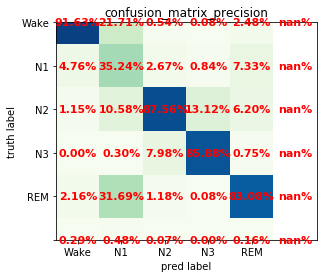

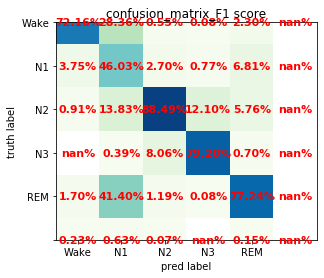

sensitivity
tensor([0.5951, 0.6636, 0.8944, 0.7348, 0.7216, 0.0000])
specificity
tensor([0.9934, 0.8795, 0.9002, 0.9799, 0.9591, 1.0000])
recall
tensor([0.5951, 0.6636, 0.8944, 0.7348, 0.7216, 0.0000])
precision
tensor([0.9163, 0.3524, 0.8756, 0.8588, 0.8308,    nan])
f1_score
tensor([0.7216, 0.4603, 0.8849, 0.7920, 0.7724,    nan])


In [26]:


def check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path):
    n_categories = 6
    columns_format = ['Wake','N1','N2','N3','REM','None']

    dataset = search_npy_list(test_signals_dir)
    print(dataset)


    model = DeepSleepNet_Classification()

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    test_total_loss = 0.0
    test_total_count = 0
    test_total_data = 0

    model.load_state_dict(torch.load(load_filename))

    confusion = torch.zeros(n_categories, n_categories)

    # 평가 모델 사용
    model.eval()
    for file_name in dataset:
        # get_signal_each_onechannel()
        batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=0,noise_scale=0,
                                                                         preprocessing=True,norm_methods='Standard')
        #print(batch_signal.shape)
        batch_label_cpu = batch_label
        batch_label = torch.from_numpy(batch_label).long().to(device)
        batch_signal = signals_expand_torch_one_channel(batch_signal)
        
        with torch.no_grad():
            for index,batch_signal_each in enumerate(batch_signal):
                pred = model(batch_signal_each.reshape(1,1,-1))

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label[index]).sum().item()
                batch_label_one = batch_label[index].cpu().numpy()
                predict = predict.cpu().numpy()
                
                
                confusion[batch_label[index]][predict] += 1

                test_total_count += check_count
                test_total_data += len(pred)
    print(confusion)
    confusion_percent = torch.zeros(n_categories, n_categories)
    confusion_percent_recall = torch.zeros(n_categories, n_categories)
    sensitivity = torch.zeros(n_categories)
    specificity = torch.zeros(n_categories)
    recall = torch.zeros(n_categories)
    precision = torch.zeros(n_categories)
    f1_score = torch.zeros(n_categories)

    tp_fp = confusion.sum(dim=0)
    tp_fn = confusion.sum(dim=1)
    tn_fp = torch.zeros(n_categories)
    for i in range(6):
        for z in range(6):
            if z != i:
                tn_fp[i] += tp_fn[z]
    for index in range(n_categories):
        confusion_percent[index] = confusion[index] / tp_fp.float()
        confusion_percent_recall[index] = confusion[index] / tp_fn.float()
        tn = confusion.sum() - confusion.sum(dim=0)[index] - confusion.sum(dim=1)[index] + confusion[index][index]
        sensitivity[index] = confusion[index][index] / float(tp_fn[index])
        specificity[index] = tn / float(tn_fp[index])
        precision[index] = confusion[index][index] / float(tp_fp[index])

        recall[index] = sensitivity[index]

    f1_score = 2 * (precision * recall) / (precision + recall)
    test_total_loss /= len(dataset)
    test_accuracy = test_total_count / test_total_data * 100
    print('Total data accuracy : %d/%d -> %.4f%%' % (test_total_count, test_total_data, test_accuracy))
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)
    confusion_percent_f1 = 2 * (confusion_percent * confusion_percent_recall) / (
                confusion_percent + confusion_percent_recall)
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent_f1[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)

    label = ['Wake', 'N1', 'N2', 'N3', 'REM']
    # Plot confusion matrix
    plt.imshow(confusion_percent, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_precision')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_%d.png')
    plt.show()

    plt.imshow(confusion_percent_f1, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent_f1):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_F1 score')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_f1score_%d.png')
    plt.show()

    print('sensitivity')
    print(sensitivity)
    print('specificity')
    print(specificity)
    print('recall')
    print(recall)
    print('precision')
    print(precision)
    print('f1_score')
    print(f1_score)

def make_result_channel_new():
    load_filename = './train.pth'
    logging_filename = './logging.txt'
    save_path = './result/'
    os.makedirs(save_path,exist_ok=True)
    test_signals_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
    annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
    check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path)
make_result_channel_new()

In [27]:
save_filename = './train.pth'
logging_filename = './logging.txt'
train_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/each/'
test_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, 
                           test_signal_dir,annotations_dir,
                           epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                           layer_filters=[64,128,256,512],first_conv=[200,40,100],
                           optim='Adam',lf='CE',epsilon=0.8,noise_scale=1,
                           min_value=-0,max_value=0,preprocessing=True,
                           norm_methods='Standard',use_noise=True,loss_type='softmax')

33941
can use CUDA!!!
torch.cuda.device_count() :  1
Optimizer : Adam
current_lr : 0.001000
13.775829553604126
7
train dataset : 1/2000 epochs spend time : 36.2884 sec / total_loss : 1.9680 correct : 14052/33941 -> 41.4013%
test dataset : 1/2000 epochs spend time : 0.5141 sec  / total_loss : 1.9963 correct : 4691/9821 -> 47.7650%
best epoch : 1/2000 / val accuracy : 47.764993%
current_lr : 0.001000
7.4334699511528015
7
train dataset : 2/2000 epochs spend time : 35.0413 sec / total_loss : 1.0619 correct : 22102/33941 -> 65.1189%
test dataset : 2/2000 epochs spend time : 0.5221 sec  / total_loss : 1.8658 correct : 5384/9821 -> 54.8213%
best epoch : 2/2000 / val accuracy : 54.821301%
current_lr : 0.001000
5.957632839679718
7
train dataset : 3/2000 epochs spend time : 35.0753 sec / total_loss : 0.8511 correct : 25382/33941 -> 74.7827%
test dataset : 3/2000 epochs spend time : 0.5231 sec  / total_loss : 1.4807 correct : 6040/9821 -> 61.5009%
best epoch : 3/2000 / val accuracy : 61.500865%
c

4.3197014927864075
7
train dataset : 25/2000 epochs spend time : 38.7799 sec / total_loss : 0.6171 correct : 28031/33941 -> 82.5874%
test dataset : 25/2000 epochs spend time : 0.5477 sec  / total_loss : 1.1065 correct : 6833/9821 -> 69.5754%
best epoch : 25/2000 / val accuracy : 69.575400%
current_lr : 0.001000
4.312192678451538
7
train dataset : 26/2000 epochs spend time : 37.9626 sec / total_loss : 0.6160 correct : 28068/33941 -> 82.6964%
test dataset : 26/2000 epochs spend time : 0.5311 sec  / total_loss : 1.1358 correct : 6788/9821 -> 69.1172%
best epoch : 25/2000 / val accuracy : 69.575400%
current_lr : 0.001000
4.277885258197784
7
train dataset : 27/2000 epochs spend time : 36.8100 sec / total_loss : 0.6111 correct : 28110/33941 -> 82.8202%
test dataset : 27/2000 epochs spend time : 0.5171 sec  / total_loss : 1.2495 correct : 6833/9821 -> 69.5754%
best epoch : 25/2000 / val accuracy : 69.575400%
current_lr : 0.001000
4.220045626163483
7
train dataset : 28/2000 epochs spend time :

4.223692893981934
7
train dataset : 49/2000 epochs spend time : 59.6506 sec / total_loss : 0.6034 correct : 28168/33941 -> 82.9911%
test dataset : 49/2000 epochs spend time : 0.6583 sec  / total_loss : 1.0955 correct : 6966/9821 -> 70.9296%
best epoch : 41/2000 / val accuracy : 71.123104%
current_lr : 0.001000
3.980253577232361
7
train dataset : 50/2000 epochs spend time : 59.4209 sec / total_loss : 0.5686 correct : 28652/33941 -> 84.4171%
test dataset : 50/2000 epochs spend time : 0.6420 sec  / total_loss : 1.2295 correct : 6813/9821 -> 69.3718%
best epoch : 41/2000 / val accuracy : 71.123104%
current_lr : 0.001000
3.7796157002449036
7
train dataset : 51/2000 epochs spend time : 58.7401 sec / total_loss : 0.5399 correct : 29022/33941 -> 85.5072%
test dataset : 51/2000 epochs spend time : 0.6485 sec  / total_loss : 1.0654 correct : 6794/9821 -> 69.1783%
best epoch : 41/2000 / val accuracy : 71.123104%
current_lr : 0.001000
3.7956398129463196
7
train dataset : 52/2000 epochs spend time 

3.2591753005981445
7
train dataset : 73/2000 epochs spend time : 56.6312 sec / total_loss : 0.4656 correct : 30013/33941 -> 88.4270%
test dataset : 73/2000 epochs spend time : 0.5498 sec  / total_loss : 1.0622 correct : 6932/9821 -> 70.5834%
best epoch : 59/2000 / val accuracy : 71.336931%
current_lr : 0.000250
3.2741698920726776
7
train dataset : 74/2000 epochs spend time : 41.5791 sec / total_loss : 0.4677 correct : 29956/33941 -> 88.2590%
test dataset : 74/2000 epochs spend time : 0.5904 sec  / total_loss : 0.9946 correct : 7023/9821 -> 71.5100%
best epoch : 74/2000 / val accuracy : 71.510030%
current_lr : 0.000250
3.2500259280204773
7
train dataset : 75/2000 epochs spend time : 40.5827 sec / total_loss : 0.4643 correct : 30034/33941 -> 88.4888%
test dataset : 75/2000 epochs spend time : 0.5062 sec  / total_loss : 1.1196 correct : 6962/9821 -> 70.8889%
best epoch : 74/2000 / val accuracy : 71.510030%
current_lr : 0.000125
3.2261639535427094
7
train dataset : 76/2000 epochs spend tim

3.098517119884491
7
train dataset : 97/2000 epochs spend time : 37.5751 sec / total_loss : 0.4426 correct : 30296/33941 -> 89.2608%
test dataset : 97/2000 epochs spend time : 0.4954 sec  / total_loss : 1.0813 correct : 7040/9821 -> 71.6831%
best epoch : 97/2000 / val accuracy : 71.683128%
current_lr : 0.000031
3.0887222290039062
7
train dataset : 98/2000 epochs spend time : 37.1527 sec / total_loss : 0.4412 correct : 30309/33941 -> 89.2991%
test dataset : 98/2000 epochs spend time : 0.4944 sec  / total_loss : 1.0856 correct : 6943/9821 -> 70.6954%
best epoch : 97/2000 / val accuracy : 71.683128%
current_lr : 0.000031
3.09782537817955
7
train dataset : 99/2000 epochs spend time : 36.6853 sec / total_loss : 0.4425 correct : 30315/33941 -> 89.3168%
test dataset : 99/2000 epochs spend time : 0.4994 sec  / total_loss : 1.0849 correct : 6953/9821 -> 70.7973%
best epoch : 97/2000 / val accuracy : 71.683128%
current_lr : 0.000031
3.0897743105888367
7
train dataset : 100/2000 epochs spend time 

3.064166694879532
7
train dataset : 121/2000 epochs spend time : 35.4713 sec / total_loss : 0.4377 correct : 30364/33941 -> 89.4611%
test dataset : 121/2000 epochs spend time : 0.4954 sec  / total_loss : 1.1031 correct : 6997/9821 -> 71.2453%
best epoch : 97/2000 / val accuracy : 71.683128%
current_lr : 0.000008
3.060985714197159
7
train dataset : 122/2000 epochs spend time : 35.1400 sec / total_loss : 0.4373 correct : 30404/33941 -> 89.5790%
test dataset : 122/2000 epochs spend time : 0.4944 sec  / total_loss : 1.1027 correct : 6959/9821 -> 70.8584%
best epoch : 97/2000 / val accuracy : 71.683128%
current_lr : 0.000008
3.05043226480484
7
train dataset : 123/2000 epochs spend time : 36.8014 sec / total_loss : 0.4358 correct : 30387/33941 -> 89.5289%
test dataset : 123/2000 epochs spend time : 0.4954 sec  / total_loss : 1.0920 correct : 6950/9821 -> 70.7667%
best epoch : 97/2000 / val accuracy : 71.683128%
current_lr : 0.000008
3.068007171154022
7
train dataset : 124/2000 epochs spend t

#### Noise 있는 상태로 학습

['SC4002EC-Hypnogram.npy', 'SC4022EJ-Hypnogram.npy', 'SC4031EC-Hypnogram.npy', 'SC4042EC-Hypnogram.npy', 'SC4072EH-Hypnogram.npy', 'SC4101EC-Hypnogram.npy', 'SC4141EU-Hypnogram.npy', 'SC4151EC-Hypnogram.npy', 'SC4182EC-Hypnogram.npy', 'SC4192EV-Hypnogram.npy']
can use CUDA!!!
tensor([[7.5900e+02, 2.3200e+02, 1.5000e+01, 0.0000e+00, 6.1000e+01, 0.0000e+00],
        [6.1000e+01, 5.7600e+02, 1.9000e+01, 0.0000e+00, 2.2700e+02, 0.0000e+00],
        [1.2000e+01, 2.4500e+02, 3.4540e+03, 4.2000e+01, 5.6600e+02, 0.0000e+00],
        [1.0000e+00, 1.0000e+01, 4.7600e+02, 8.8300e+02, 2.9000e+01, 0.0000e+00],
        [3.6000e+01, 2.2400e+02, 2.0000e+00, 0.0000e+00, 1.8750e+03, 0.0000e+00],
        [3.0000e+00, 8.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00]])
Total data accuracy : 7547/9821 -> 76.8455%
87.04 44.48 87.02 95.46 67.93 nan 
78.29 52.89 83.35 75.99 76.58 nan 


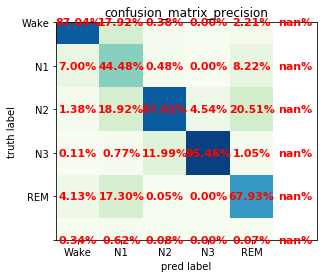

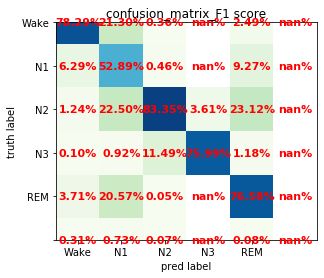

sensitivity
tensor([0.7113, 0.6523, 0.7997, 0.6312, 0.8774, 0.0000])
specificity
tensor([0.9871, 0.9196, 0.9064, 0.9950, 0.8848, 1.0000])
recall
tensor([0.7113, 0.6523, 0.7997, 0.6312, 0.8774, 0.0000])
precision
tensor([0.8704, 0.4448, 0.8702, 0.9546, 0.6793,    nan])
f1_score
tensor([0.7829, 0.5289, 0.8335, 0.7599, 0.7658,    nan])


In [28]:


def check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path):
    n_categories = 6
    columns_format = ['Wake','N1','N2','N3','REM','None']

    dataset = search_npy_list(test_signals_dir)
    print(dataset)


    model = DeepSleepNet_Classification()

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    test_total_loss = 0.0
    test_total_count = 0
    test_total_data = 0

    model.load_state_dict(torch.load(load_filename))

    confusion = torch.zeros(n_categories, n_categories)

    # 평가 모델 사용
    model.eval()
    for file_name in dataset:
        # get_signal_each_onechannel()
        batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=0,noise_scale=0,
                                                                         preprocessing=True,norm_methods='Standard')
        #print(batch_signal.shape)
        batch_label_cpu = batch_label
        batch_label = torch.from_numpy(batch_label).long().to(device)
        batch_signal = signals_expand_torch_one_channel(batch_signal)
        
        with torch.no_grad():
            for index,batch_signal_each in enumerate(batch_signal):
                pred = model(batch_signal_each.reshape(1,1,-1))

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label[index]).sum().item()
                batch_label_one = batch_label[index].cpu().numpy()
                predict = predict.cpu().numpy()
                
                
                confusion[batch_label[index]][predict] += 1

                test_total_count += check_count
                test_total_data += len(pred)
    print(confusion)
    confusion_percent = torch.zeros(n_categories, n_categories)
    confusion_percent_recall = torch.zeros(n_categories, n_categories)
    sensitivity = torch.zeros(n_categories)
    specificity = torch.zeros(n_categories)
    recall = torch.zeros(n_categories)
    precision = torch.zeros(n_categories)
    f1_score = torch.zeros(n_categories)

    tp_fp = confusion.sum(dim=0)
    tp_fn = confusion.sum(dim=1)
    tn_fp = torch.zeros(n_categories)
    for i in range(6):
        for z in range(6):
            if z != i:
                tn_fp[i] += tp_fn[z]
    for index in range(n_categories):
        confusion_percent[index] = confusion[index] / tp_fp.float()
        confusion_percent_recall[index] = confusion[index] / tp_fn.float()
        tn = confusion.sum() - confusion.sum(dim=0)[index] - confusion.sum(dim=1)[index] + confusion[index][index]
        sensitivity[index] = confusion[index][index] / float(tp_fn[index])
        specificity[index] = tn / float(tn_fp[index])
        precision[index] = confusion[index][index] / float(tp_fp[index])

        recall[index] = sensitivity[index]

    f1_score = 2 * (precision * recall) / (precision + recall)
    test_total_loss /= len(dataset)
    test_accuracy = test_total_count / test_total_data * 100
    print('Total data accuracy : %d/%d -> %.4f%%' % (test_total_count, test_total_data, test_accuracy))
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)
    confusion_percent_f1 = 2 * (confusion_percent * confusion_percent_recall) / (
                confusion_percent + confusion_percent_recall)
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent_f1[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)

    label = ['Wake', 'N1', 'N2', 'N3', 'REM']
    # Plot confusion matrix
    plt.imshow(confusion_percent, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_precision')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_%d.png')
    plt.show()

    plt.imshow(confusion_percent_f1, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent_f1):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_F1 score')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_f1score_%d.png')
    plt.show()

    print('sensitivity')
    print(sensitivity)
    print('specificity')
    print(specificity)
    print('recall')
    print(recall)
    print('precision')
    print(precision)
    print('f1_score')
    print(f1_score)

def make_result_channel_new():
    load_filename = './train.pth'
    logging_filename = './logging.txt'
    save_path = './result/'
    os.makedirs(save_path,exist_ok=True)
    test_signals_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
    annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
    check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path)
make_result_channel_new()

#### use Noise

#### 4258.  2762. 17340.  2000.  7522.    59 결과

In [21]:
def train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, test_signal_dir,annotations_dir
                               ,epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                               layer_filters=[64,128,256,512],first_conv=[200,40,100],optim='Adam',lf='CE',
                               epsilon=0.7,noise_scale=2e-6,min_value=-1e-4,max_value=1e-4,preprocessing=True,
                               norm_methods='Standard',use_noise=True,loss_type='softmax'):
    # Adam optimizer param
    b1 = 0.5
    b2 = 0.999

    beta = 0.001

    check_file = open(logging_filename, 'w')  # logging file

    train_dataset_list = []
    
    for i in range(6):
        if i == 3:
            train_dataset_list.append(search_npy_list_withdir(train_signal_dir+'%d/'%i))
        else:
            train_dataset_list.append(search_npy_list_withdir(train_signal_dir+'%d/'%i))
    
    train_dataset_list = list(itertools.chain(*train_dataset_list))
    print(len(train_dataset_list))

    best_accuracy = 0.
    best_epoch = 0

    test_dataset_list = search_npy_list(test_signal_dir)

    train_dataset_len = len(train_dataset_list)
    test_dataset_len = len(test_dataset_list)
    test_batch_size = test_dataset_len


    model = DeepSleepNet_Classification()

    #model = resnet18_200hz(in_channel=1,layer_filters=layer_filters,first_conv=first_conv,use_batchnorm=True,num_classes=5)

    model.apply(weights_init) # weight init

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()
    #summary(model,[1,6000])
    print('torch.cuda.device_count() : ', torch.cuda.device_count())
    if torch.cuda.device_count() > 1:
        print('Multi GPU Activation !!!')
        #model = nn.DataParallel(model)

    # loss funcition
    if lf == 'CE':
        loss_fn = nn.CrossEntropyLoss().to(device)
    elif lf == 'CEW':
        samples_per_cls = [27,15,41,5,11]
        no_of_classes = 5
        effective_num = 1.0 - np.power(beta,samples_per_cls)
        #print(effective_num)
        weights = (1.0 - beta) / np.array(effective_num)
        #print(weights)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights).float()
        weights = weights.to(device)
        loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)
    elif lf == 'FL':
        loss_fn = FocalLoss(gamma=2).to(device)
    elif lf == 'CBL':
        loss_fn = CB_loss(samples_per_cls=[27,15,41,5,11],no_of_classes=5,loss_type=loss_type,beta=0.9999,gamma=2.0)
    #loss_fn = FocalLoss(gamma=2).to(device)

    # optimizer ADAM (SGD의 경우에는 정상적으로 학습이 진행되지 않았음)
    if optim == 'Adam':
        print('Optimizer : Adam')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(b1, b2))
    elif optim == 'RMS':
        print('Optimizer : RMSprop')
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optim == 'SGD':
        print('Optimizer : SGD')
        optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=gamma, patience=10,
                                                           min_lr=1e-6)
    #stride = 40 일 때, batch_size = 20이면 16GB정도의 메모리 사용
    batch_size = 5000
    norm_square = 2

    
    for epoch in range(epochs):
        train_dataset = suffle_dataset_list(train_dataset_list) # 매 epoch마다 train_dataset shuffle !
        count = 0  # check batch
        train_total_loss = 0.0
        train_total_count = 0
        train_total_data = 0

        val_total_loss = 0.0
        val_total_count = 0
        val_total_data = 0

        test_total_loss = 0.0
        test_total_count = 0
        test_total_data = 0

        start_time = time.time()
        model.train()
        output_str = 'current_lr : %f\n'%(optimizer.state_dict()['param_groups'][0]['lr'])
        sys.stdout.write(output_str)
        check_file.write(output_str)
        train_size = 0
        for index, file_name in enumerate(train_dataset):
            if index % batch_size == 0:
                batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut_each(file_name,
                                                                         use_noise=use_noise,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)
            else:
                new_signal, new_label = get_dataset_one_channel_norm_withoutCut_each(file_name,
                                                                         use_noise=use_noise,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)

                batch_signal = torch.cat((batch_signal, new_signal),dim=1)
                batch_label = np.concatenate((batch_label, new_label))
            count += 1
            if count == batch_size or index == len(train_dataset) - 1:  # batch 학습 시작!
                batch_signal = signals_expand_torch_one_channel(batch_signal)
                #batch_signal = signals_expand_torch_one_channel(batch_signal)
                # batch_signal = torch.from_numpy(batch_signal).float().to(device)
                batch_label = torch.from_numpy(batch_label).long().to(device)
                optimizer.zero_grad()
                # print(batch_signal.shape)
                # print(batch_signal)
                pred = model(batch_signal)
                norm = 0

                for parameter in model.parameters():
                    norm += torch.norm(parameter, p=norm_square)

                loss = loss_fn(pred, batch_label) + beta * norm
                #print('loss : ',loss.item())
                # loss = loss_fn(pred, batch_label)
                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label).sum().item()

                train_total_loss += loss.item()
                train_size +=1
                train_total_count += check_count
                train_total_data += len(batch_signal)
                loss.backward()
                optimizer.step()

                del (batch_signal)
                del (batch_label)
                del (loss)
                del (pred)
                torch.cuda.empty_cache()
                count = 0
        print(train_total_loss)
        print(train_size)
        train_total_loss /= train_size
        train_accuracy = train_total_count / int(len(train_dataset_list)) * 100

        output_str = 'train dataset : %d/%d epochs spend time : %.4f sec / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                     % (epoch + 1, epochs, time.time() - start_time, train_total_loss,
                        train_total_count, train_total_data, train_accuracy)
        sys.stdout.write(output_str)
        check_file.write(output_str)

    

        #check test dataset
        start_time = time.time()
        for file_name in test_dataset_list:
            batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=epsilon,noise_scale=noise_scale,
                                                                         preprocessing=preprocessing,norm_methods=norm_methods)

            batch_signal = signals_expand_torch_one_channel(batch_signal)

            batch_label = torch.from_numpy(batch_label).long().to(device)

            with torch.no_grad():
                pred = model(batch_signal)

                loss = loss_fn(pred, batch_label)

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label).sum().item()

                test_total_loss += loss.item()
                test_total_count += check_count
                test_total_data += len(batch_signal)

                # 사용하지 않는 변수 제거
                del (batch_signal)
                del (batch_label)
                del (loss)
                del (pred)
                torch.cuda.empty_cache()
        test_total_loss /= test_batch_size
        test_accuracy = test_total_count / test_total_data * 100



        output_str = 'test dataset : %d/%d epochs spend time : %.4f sec  / total_loss : %.4f correct : %d/%d -> %.4f%%\n' \
                     % (epoch + 1, epochs, time.time() - start_time, test_total_loss,
                        test_total_count, test_total_data, test_accuracy)
        sys.stdout.write(output_str)
        check_file.write(output_str)

        scheduler.step(float(test_total_loss))
        #scheduler.step()

        if epoch == 0:
            best_accuracy = test_accuracy
            best_epoch = epoch
            save_file = save_filename
            #save_file = save_path + 'best_SleepEEGNet_CNN_channel%d.pth'%channel
            torch.save(model.state_dict(),save_file)
            stop_count = 0
        else:
            if best_accuracy < test_accuracy:
                best_accuracy = test_accuracy
                best_epoch = epoch
                save_file = save_filename
                torch.save(model.state_dict(), save_file)
                stop_count = 0
            else:
                stop_count += 1
        if stop_count > 30:
            print('Early Stopping')
            break

        output_str = 'best epoch : %d/%d / val accuracy : %f%%\n' \
                     % (best_epoch+1, epochs, best_accuracy)
        sys.stdout.write(output_str)
        print('=' * 30)


    output_str = 'best epoch : %d/%d / accuracy : %f%%\n' \
                 % (best_epoch+1, epochs, best_accuracy)
    sys.stdout.write(output_str)
    check_file.write(output_str)
    print('=' * 30)

    check_file.close()



In [22]:
save_filename = './train.pth'
logging_filename = './logging.txt'
train_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/each/'
test_signal_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
train_model_withNoise_norm(save_filename,logging_filename,train_signal_dir, 
                           test_signal_dir,annotations_dir,
                           epochs=2000,learning_rate=0.001,step_size=100,gamma=0.5,channel=0,
                           layer_filters=[64,128,256,512],first_conv=[200,40,100],
                           optim='Adam',lf='CE',epsilon=0,noise_scale=0,
                           min_value=-0,max_value=0,preprocessing=True,
                           norm_methods='Standard',use_noise=False,loss_type='softmax')

37516
can use CUDA!!!
torch.cuda.device_count() :  1
Optimizer : Adam
current_lr : 0.001000
16.252869129180908
8
train dataset : 1/2000 epochs spend time : 34.3865 sec / total_loss : 2.0316 correct : 14456/37516 -> 38.5329%
test dataset : 1/2000 epochs spend time : 0.5211 sec  / total_loss : 1.4639 correct : 5137/9821 -> 52.3063%
best epoch : 1/2000 / val accuracy : 52.306282%
current_lr : 0.001000
7.9093451499938965
8
train dataset : 2/2000 epochs spend time : 33.3287 sec / total_loss : 0.9887 correct : 25415/37516 -> 67.7444%
test dataset : 2/2000 epochs spend time : 0.5137 sec  / total_loss : 1.0997 correct : 6021/9821 -> 61.3074%
best epoch : 2/2000 / val accuracy : 61.307403%
current_lr : 0.001000
6.361969232559204
8
train dataset : 3/2000 epochs spend time : 33.9350 sec / total_loss : 0.7952 correct : 28614/37516 -> 76.2715%
test dataset : 3/2000 epochs spend time : 0.5537 sec  / total_loss : 0.8136 correct : 6801/9821 -> 69.2496%
best epoch : 3/2000 / val accuracy : 69.249567%
c

4.852604806423187
8
train dataset : 25/2000 epochs spend time : 34.9414 sec / total_loss : 0.6066 correct : 31074/37516 -> 82.8287%
test dataset : 25/2000 epochs spend time : 0.5122 sec  / total_loss : 0.6010 correct : 7672/9821 -> 78.1183%
best epoch : 25/2000 / val accuracy : 78.118318%
current_lr : 0.001000
5.010347962379456
8
train dataset : 26/2000 epochs spend time : 34.7941 sec / total_loss : 0.6263 correct : 30756/37516 -> 81.9810%
test dataset : 26/2000 epochs spend time : 0.5160 sec  / total_loss : 0.6002 correct : 7685/9821 -> 78.2507%
best epoch : 26/2000 / val accuracy : 78.250687%
current_lr : 0.001000
4.761001884937286
8
train dataset : 27/2000 epochs spend time : 34.9719 sec / total_loss : 0.5951 correct : 31227/37516 -> 83.2365%
test dataset : 27/2000 epochs spend time : 0.5280 sec  / total_loss : 0.6743 correct : 7388/9821 -> 75.2266%
best epoch : 26/2000 / val accuracy : 78.250687%
current_lr : 0.001000
4.769714415073395
8
train dataset : 28/2000 epochs spend time : 

4.171134531497955
8
train dataset : 49/2000 epochs spend time : 35.3809 sec / total_loss : 0.5214 correct : 32317/37516 -> 86.1419%
test dataset : 49/2000 epochs spend time : 0.5205 sec  / total_loss : 0.6428 correct : 7579/9821 -> 77.1714%
best epoch : 43/2000 / val accuracy : 78.719071%
current_lr : 0.000500
4.179974615573883
8
train dataset : 50/2000 epochs spend time : 34.6713 sec / total_loss : 0.5225 correct : 32210/37516 -> 85.8567%
test dataset : 50/2000 epochs spend time : 0.5171 sec  / total_loss : 0.6073 correct : 7696/9821 -> 78.3627%
best epoch : 43/2000 / val accuracy : 78.719071%
current_lr : 0.000500
4.196825921535492
8
train dataset : 51/2000 epochs spend time : 35.1735 sec / total_loss : 0.5246 correct : 32225/37516 -> 85.8967%
test dataset : 51/2000 epochs spend time : 0.5152 sec  / total_loss : 0.5949 correct : 7690/9821 -> 78.3016%
best epoch : 43/2000 / val accuracy : 78.719071%
current_lr : 0.000500
4.122900307178497
8
train dataset : 52/2000 epochs spend time : 

3.739384710788727
8
train dataset : 73/2000 epochs spend time : 36.3437 sec / total_loss : 0.4674 correct : 33182/37516 -> 88.4476%
test dataset : 73/2000 epochs spend time : 0.5280 sec  / total_loss : 0.5717 correct : 7768/9821 -> 79.0958%
best epoch : 70/2000 / val accuracy : 79.533652%
current_lr : 0.000250
3.71051424741745
8
train dataset : 74/2000 epochs spend time : 36.1456 sec / total_loss : 0.4638 correct : 33132/37516 -> 88.3143%
test dataset : 74/2000 epochs spend time : 0.5508 sec  / total_loss : 0.5472 correct : 7896/9821 -> 80.3991%
best epoch : 74/2000 / val accuracy : 80.399145%
current_lr : 0.000250
3.7267709970474243
8
train dataset : 75/2000 epochs spend time : 35.9157 sec / total_loss : 0.4658 correct : 33128/37516 -> 88.3037%
test dataset : 75/2000 epochs spend time : 0.5369 sec  / total_loss : 0.5698 correct : 7789/9821 -> 79.3096%
best epoch : 74/2000 / val accuracy : 80.399145%
current_lr : 0.000250
3.7070908546447754
8
train dataset : 76/2000 epochs spend time :

3.4236287474632263
8
train dataset : 97/2000 epochs spend time : 34.5487 sec / total_loss : 0.4280 correct : 33627/37516 -> 89.6338%
test dataset : 97/2000 epochs spend time : 0.5112 sec  / total_loss : 0.5823 correct : 7798/9821 -> 79.4013%
best epoch : 74/2000 / val accuracy : 80.399145%
current_lr : 0.000125
3.410710573196411
8
train dataset : 98/2000 epochs spend time : 35.2477 sec / total_loss : 0.4263 correct : 33688/37516 -> 89.7964%
test dataset : 98/2000 epochs spend time : 0.5072 sec  / total_loss : 0.5764 correct : 7761/9821 -> 79.0245%
best epoch : 74/2000 / val accuracy : 80.399145%
current_lr : 0.000125
3.3794360756874084
8
train dataset : 99/2000 epochs spend time : 33.7126 sec / total_loss : 0.4224 correct : 33810/37516 -> 90.1215%
test dataset : 99/2000 epochs spend time : 0.5132 sec  / total_loss : 0.5695 correct : 7826/9821 -> 79.6864%
best epoch : 74/2000 / val accuracy : 80.399145%
current_lr : 0.000125
3.381411135196686
8
train dataset : 100/2000 epochs spend time

['SC4002EC-Hypnogram.npy', 'SC4022EJ-Hypnogram.npy', 'SC4031EC-Hypnogram.npy', 'SC4042EC-Hypnogram.npy', 'SC4072EH-Hypnogram.npy', 'SC4101EC-Hypnogram.npy', 'SC4141EU-Hypnogram.npy', 'SC4151EC-Hypnogram.npy', 'SC4182EC-Hypnogram.npy', 'SC4192EV-Hypnogram.npy']
can use CUDA!!!
tensor([[7.0100e+02, 2.8300e+02, 1.2000e+01, 0.0000e+00, 7.1000e+01, 0.0000e+00],
        [1.6000e+01, 6.4800e+02, 2.1000e+01, 2.0000e+00, 1.9600e+02, 0.0000e+00],
        [3.0000e+00, 2.6800e+02, 3.4200e+03, 2.2200e+02, 4.0600e+02, 0.0000e+00],
        [0.0000e+00, 2.0000e+00, 6.6000e+01, 1.3200e+03, 1.1000e+01, 0.0000e+00],
        [4.0000e+00, 2.8300e+02, 3.0000e+00, 0.0000e+00, 1.8470e+03, 0.0000e+00],
        [3.0000e+00, 9.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00]])
Total data accuracy : 7936/9821 -> 80.8064%
96.42 43.40 97.05 85.49 72.92 nan 
78.15 54.55 87.21 89.70 79.10 nan 


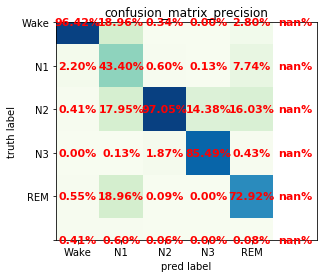

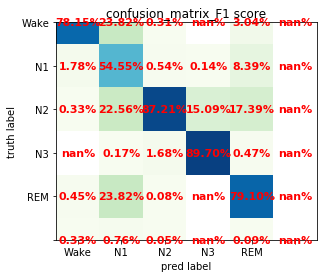

sensitivity
tensor([0.6570, 0.7339, 0.7918, 0.9435, 0.8643, 0.0000])
specificity
tensor([0.9970, 0.9055, 0.9811, 0.9734, 0.9107, 1.0000])
recall
tensor([0.6570, 0.7339, 0.7918, 0.9435, 0.8643, 0.0000])
precision
tensor([0.9642, 0.4340, 0.9705, 0.8549, 0.7292,    nan])
f1_score
tensor([0.7815, 0.5455, 0.8721, 0.8970, 0.7910,    nan])


In [23]:


def check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path):
    n_categories = 6
    columns_format = ['Wake','N1','N2','N3','REM','None']

    dataset = search_npy_list(test_signals_dir)
    print(dataset)


    model = DeepSleepNet_Classification()

    cuda = torch.cuda.is_available()

    if cuda:
        print('can use CUDA!!!')
        model = model.cuda()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    test_total_loss = 0.0
    test_total_count = 0
    test_total_data = 0

    model.load_state_dict(torch.load(load_filename))

    confusion = torch.zeros(n_categories, n_categories)

    # 평가 모델 사용
    model.eval()
    for file_name in dataset:
        # get_signal_each_onechannel()
        batch_signal, batch_label = get_dataset_one_channel_norm_withoutCut(test_signal_dir,annotations_dir,file_name,
                                                                         use_noise=False,epsilon=0,noise_scale=0,
                                                                         preprocessing=True,norm_methods='Standard')
        #print(batch_signal.shape)
        batch_label_cpu = batch_label
        batch_label = torch.from_numpy(batch_label).long().to(device)
        batch_signal = signals_expand_torch_one_channel(batch_signal)
        
        with torch.no_grad():
            for index,batch_signal_each in enumerate(batch_signal):
                pred = model(batch_signal_each.reshape(1,1,-1))

                # acc
                _, predict = torch.max(pred, 1)
                check_count = (predict == batch_label[index]).sum().item()
                batch_label_one = batch_label[index].cpu().numpy()
                predict = predict.cpu().numpy()
                
                
                confusion[batch_label[index]][predict] += 1

                test_total_count += check_count
                test_total_data += len(pred)
    print(confusion)
    confusion_percent = torch.zeros(n_categories, n_categories)
    confusion_percent_recall = torch.zeros(n_categories, n_categories)
    sensitivity = torch.zeros(n_categories)
    specificity = torch.zeros(n_categories)
    recall = torch.zeros(n_categories)
    precision = torch.zeros(n_categories)
    f1_score = torch.zeros(n_categories)

    tp_fp = confusion.sum(dim=0)
    tp_fn = confusion.sum(dim=1)
    tn_fp = torch.zeros(n_categories)
    for i in range(6):
        for z in range(6):
            if z != i:
                tn_fp[i] += tp_fn[z]
    for index in range(n_categories):
        confusion_percent[index] = confusion[index] / tp_fp.float()
        confusion_percent_recall[index] = confusion[index] / tp_fn.float()
        tn = confusion.sum() - confusion.sum(dim=0)[index] - confusion.sum(dim=1)[index] + confusion[index][index]
        sensitivity[index] = confusion[index][index] / float(tp_fn[index])
        specificity[index] = tn / float(tn_fp[index])
        precision[index] = confusion[index][index] / float(tp_fp[index])

        recall[index] = sensitivity[index]

    f1_score = 2 * (precision * recall) / (precision + recall)
    test_total_loss /= len(dataset)
    test_accuracy = test_total_count / test_total_data * 100
    print('Total data accuracy : %d/%d -> %.4f%%' % (test_total_count, test_total_data, test_accuracy))
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)
    confusion_percent_f1 = 2 * (confusion_percent * confusion_percent_recall) / (
                confusion_percent + confusion_percent_recall)
    stdout = ''
    for i in range(6):
        stdout += '%.2f '%(confusion_percent_f1[i][i]*100)
    stdout += '\n'
    sys.stdout.write(stdout)

    label = ['Wake', 'N1', 'N2', 'N3', 'REM']
    # Plot confusion matrix
    plt.imshow(confusion_percent, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_precision')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_%d.png')
    plt.show()

    plt.imshow(confusion_percent_f1, interpolation='none', cmap='GnBu')
    for (i, j), z in np.ndenumerate(confusion_percent_f1):
        # print(i, j, z)
        plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontSize=11, fontweight='bold')
    plt.title('confusion_matrix_F1 score')
    plt.xticks(np.arange(0, 6), label)
    plt.yticks(np.arange(0, 6), label)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
    plt.savefig(save_path+'confusion_matrix_f1score_%d.png')
    plt.show()

    print('sensitivity')
    print(sensitivity)
    print('specificity')
    print(specificity)
    print('recall')
    print(recall)
    print('precision')
    print(precision)
    print('f1_score')
    print(f1_score)

def make_result_channel_new():
    load_filename = './train.pth'
    logging_filename = './logging.txt'
    save_path = './result/'
    os.makedirs(save_path,exist_ok=True)
    test_signals_dir = 'D:/dataset/data_2013/origin_npy/Fpz-Cz/remove_wake/test/'
    annotations_dir = 'D:/dataset/data_2013/origin_npy/annotations/remove_wake/'
    check_ResNet_custom_Confusion(test_signals_dir,annotations_dir,load_filename,save_path)
make_result_channel_new()

#### [ 4258.  2762. 17340.  5575.  7522.    59.]